In [ ]:
# https://www.kaggle.com/datasets/kaushiksuresh147/ethereum-cryptocurrency-historical-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
df = pd.read_csv('Eth_hist.csv')

In [5]:
df.head(5)

,Date,Open,High,Low,Close,Volume
0,2016-03-10,11.20,11.85,11.07,11.75,4
1,2016-03-11,11.75,11.95,11.75,11.95,179
2,2016-03-12,11.95,13.45,11.95,12.92,833
3,2016-03-13,12.92,15.07,12.92,15.07,1295
4,2016-03-14,15.07,15.07,11.40,12.50,92183


In [6]:
df.tail(5)

,Date,Open,High,Low,Close,Volume
2376,2022-09-11,1774.38,1786.73,1722.62,1766.93,467415
2377,2022-09-12,1766.99,1782.74,1694.08,1716.42,727783
2378,2022-09-13,1716.45,1751.50,1562.30,1574.47,1304668
2379,2022-09-14,1574.41,1646.09,1556.97,1637.92,858277
2380,2022-09-15,1637.89,1653.55,1573.00,1590.58,1391957


In [7]:
df = df.drop('Date', axis=1)

In [8]:
df

,Open,High,Low,Close,Volume
0,11.20,11.85,11.07,11.75,4
1,11.75,11.95,11.75,11.95,179
2,11.95,13.45,11.95,12.92,833
3,12.92,15.07,12.92,15.07,1295
4,15.07,15.07,11.40,12.50,92183
...,...,...,...,...,...
2376,1774.38,1786.73,1722.62,1766.93,467415
2377,1766.99,1782.74,1694.08,1716.42,727783
2378,1716.45,1751.50,1562.30,1574.47,1304668
2379,1574.41,1646.09,1556.97,1637.92,858277


### Signals

In [9]:
df['short_mavg'] = df['Close'].rolling(window=10, min_periods=1, center=False).mean()
df['long_mavg'] = df['Close'].rolling(window=60, min_periods=1, center=False).mean()
df['signal'] = np.where(df['short_mavg'] > df['long_mavg'], 1.0, 0.0)


In [10]:
df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Volume        0
short_mavg    0
long_mavg     0
signal        0
dtype: int64

### Feature engineer... now we add MAs, RSI, RoC, MOM, MACD, Stochs, etc

In [11]:
def SMA(df):
    df['SMA_21days'] = df.iloc[:,3].rolling(window=21).mean()
    df['SMA_50days'] = df.iloc[:,3].rolling(window=50).mean()
    df['SMA_100days'] = df.iloc[:,3].rolling(window=100).mean()
    df['SMA_150days'] = df.iloc[:,3].rolling(window=150).mean()
SMA(df)

In [12]:
def EMA(df):
    df['EMA_21days'] = df['Close'].ewm(span=21,adjust=False).mean()
    df['EMA_50days'] = df['Close'].ewm(span=50,adjust=False).mean()
    df['EMA_100days'] = df['Close'].ewm(span=100,adjust=False).mean()
    df['EMA_150days'] = df['Close'].ewm(span=150,adjust=False).mean()
EMA(df)

In [13]:
def RSIs(df,n):
    df['diff'] = df.Close.diff()
    df['pos'] = df['diff'].clip(lower=0)
    df['neg'] = -1*df['diff'].clip(upper=0)
    ema_pos = df['pos'].ewm(com=(n-1), adjust=False).mean()
    ema_neg = df['neg'].ewm(com=(n-1), adjust=False).mean()
    relative_str = ema_pos / ema_neg
    df['RSI'+str(n)] = 100-(100/(1+relative_str))
    df['Stochastic_RSI'+str(n)] = (df['RSI'+str(n)]-df['RSI'+str(n)].rolling(n).min())/(df['RSI'+str(n)].rolling(n).max()-(df['RSI'+str(n)].rolling(n).min()))
RSIs(df, 21)
RSIs(df, 50)
RSIs(df, 100)
RSIs(df, 150)

In [14]:
def ROC(df, n):
    M = df.diff(n-1)
    N = df.shift(n-1)
    ROC = pd.Series(((M/N)*100),name='Roc_'+str(n))
    return ROC
df['ROC21'] = ROC(df['Close'],21)
df['ROC50'] = ROC(df['Close'],50)
df['ROC100'] = ROC(df['Close'],100)
df['ROC150'] = ROC(df['Close'],150)

In [15]:
def MOM(df,n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
df['MOM21'] = MOM(df['Close'], 21)
df['MOM50'] = MOM(df['Close'], 50)
df['MOM100'] = MOM(df['Close'], 100)
df['MOM150'] = MOM(df['Close'], 150)

In [16]:
def MACD(df): #default is 12-26-9
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1-exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
MACD(df)

In [17]:
def Stochastic(df,n):
    high = df['High'].rolling(n).max()
    low = df['Low'].rolling(n).min()
    df['%K'+str(n)] = (df['Close']-low)*100/(high-low) #current price in relation to the asset's recent price change
    df['%D'+str(n)] = df['%K'+str(n)].rolling(3).mean() #3 period average of %K
Stochastic(df,21)
Stochastic(df,50)
Stochastic(df,100)
Stochastic(df,150)

In [18]:
df.shape

(2381, 45)

In [19]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'short_mavg', 'long_mavg',
       'signal', 'SMA_21days', 'SMA_50days', 'SMA_100days', 'SMA_150days',
       'EMA_21days', 'EMA_50days', 'EMA_100days', 'EMA_150days', 'diff', 'pos',
       'neg', 'RSI21', 'Stochastic_RSI21', 'RSI50', 'Stochastic_RSI50',
       'RSI100', 'Stochastic_RSI100', 'RSI150', 'Stochastic_RSI150', 'ROC21',
       'ROC50', 'ROC100', 'ROC150', 'MOM21', 'MOM50', 'MOM100', 'MOM150',
       'MACD', 'Signal_Line', '%K21', '%D21', '%K50', '%D50', '%K100', '%D100',
       '%K150', '%D150'],
      dtype='object')

In [20]:
df = df.drop(['diff', 'pos', 'neg'],axis=1)

In [21]:
df.isnull().sum()

Open                   0
High                   0
Low                    0
Close                  0
Volume                 0
short_mavg             0
long_mavg              0
signal                 0
SMA_21days            20
SMA_50days            49
SMA_100days           99
SMA_150days          149
EMA_21days             0
EMA_50days             0
EMA_100days            0
EMA_150days            0
RSI21                  1
Stochastic_RSI21      21
RSI50                  1
Stochastic_RSI50      50
RSI100                 1
Stochastic_RSI100    100
RSI150                 1
Stochastic_RSI150    150
ROC21                 20
ROC50                 49
ROC100                99
ROC150               149
MOM21                 21
MOM50                 50
MOM100               100
MOM150               150
MACD                   0
Signal_Line            0
%K21                  20
%D21                  22
%K50                  49
%D50                  51
%K100                 99
%D100                101


In [22]:
df.shape

(2381, 42)

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'short_mavg'}>],
       [<AxesSubplot:title={'center':'long_mavg'}>,
        <AxesSubplot:title={'center':'signal'}>,
        <AxesSubplot:title={'center':'SMA_21days'}>,
        <AxesSubplot:title={'center':'SMA_50days'}>,
        <AxesSubplot:title={'center':'SMA_100days'}>,
        <AxesSubplot:title={'center':'SMA_150days'}>],
       [<AxesSubplot:title={'center':'EMA_21days'}>,
        <AxesSubplot:title={'center':'EMA_50days'}>,
        <AxesSubplot:title={'center':'EMA_100days'}>,
        <AxesSubplot:title={'center':'EMA_150days'}>,
        <AxesSubplot:title={'center':'RSI21'}>,
        <AxesSubplot:title={'center':'Stochastic_RSI21'}>],
       [<AxesSubplot:title={'center':'RSI50'}>,
        <AxesSubplot:ti

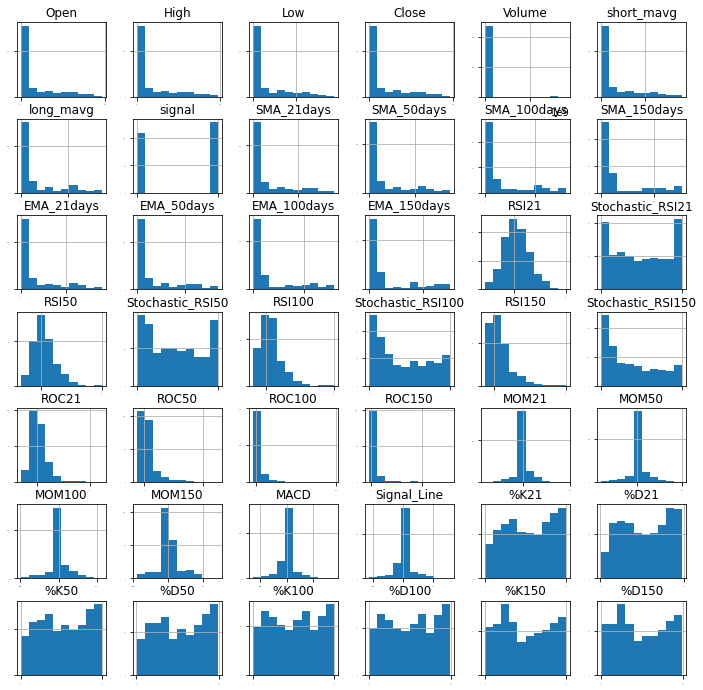

In [23]:
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))

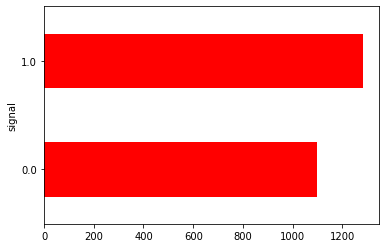

In [24]:
fig = plt.figure()
plot = df.groupby(['signal']).size().plot(kind='barh', color='red')
plt.show()

<AxesSubplot:>

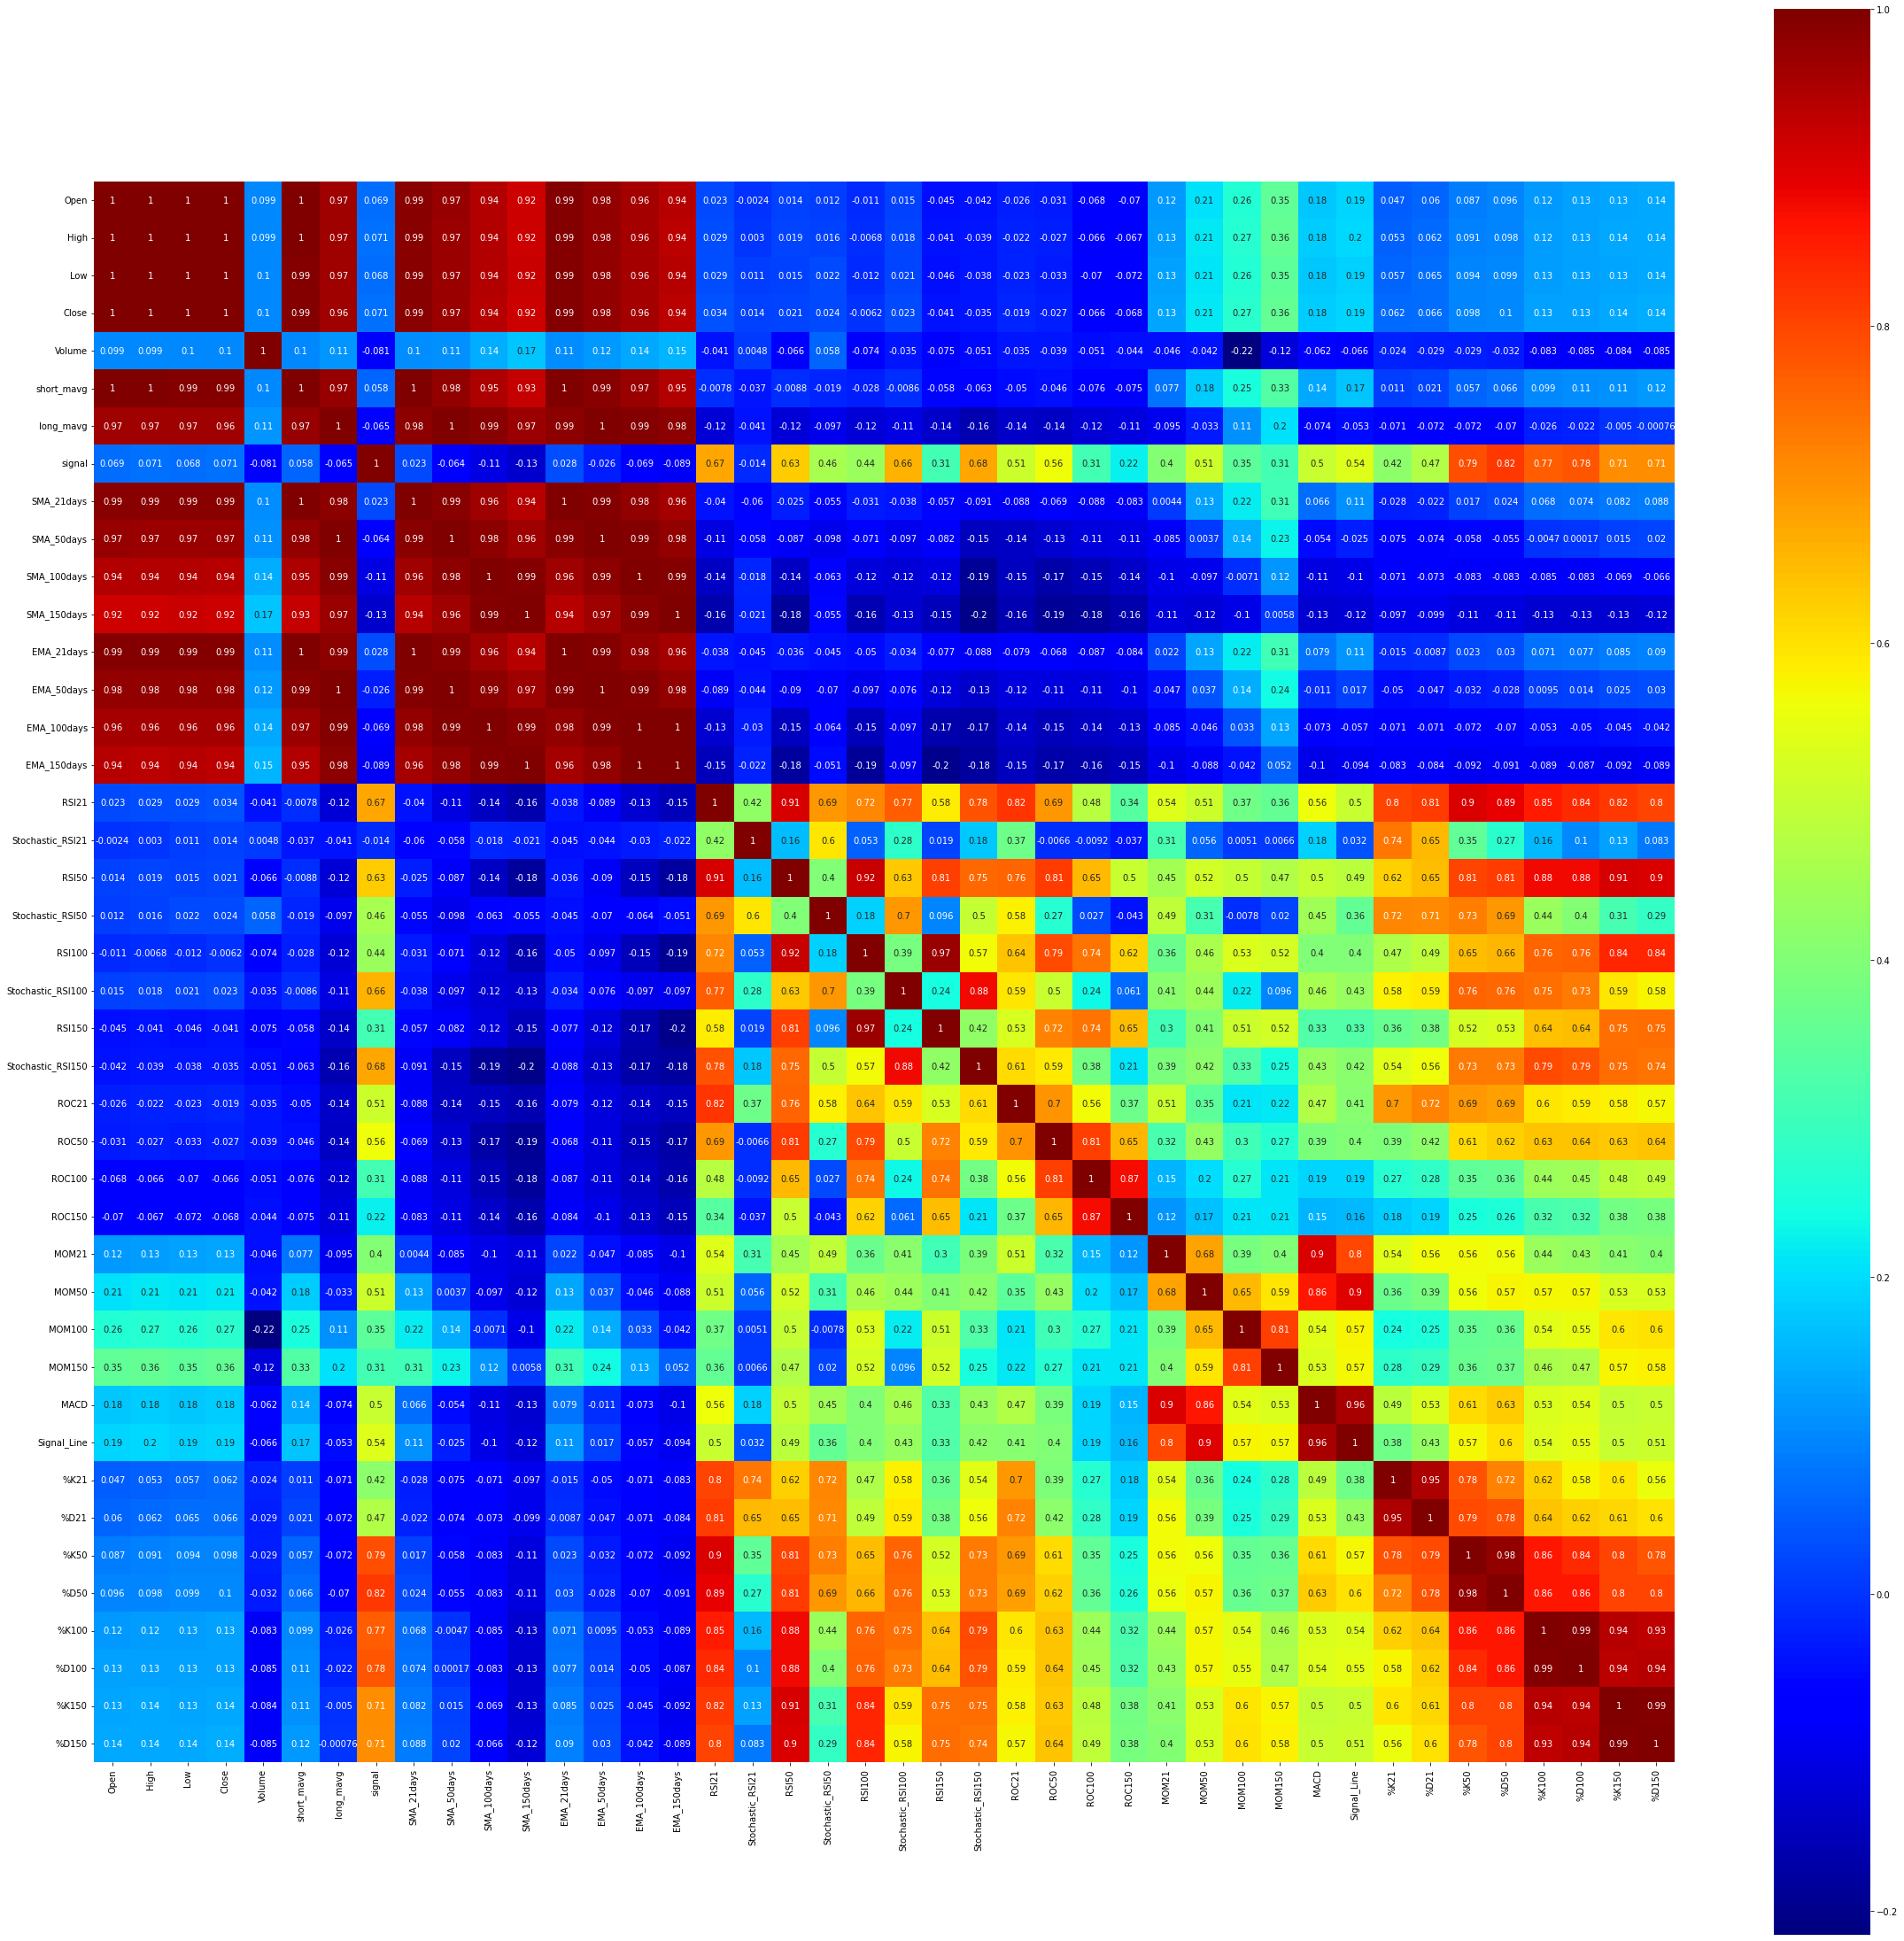

In [25]:
correlation = df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='jet')

In [26]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'short_mavg', 'long_mavg',
       'signal', 'SMA_21days', 'SMA_50days', 'SMA_100days', 'SMA_150days',
       'EMA_21days', 'EMA_50days', 'EMA_100days', 'EMA_150days', 'RSI21',
       'Stochastic_RSI21', 'RSI50', 'Stochastic_RSI50', 'RSI100',
       'Stochastic_RSI100', 'RSI150', 'Stochastic_RSI150', 'ROC21', 'ROC50',
       'ROC100', 'ROC150', 'MOM21', 'MOM50', 'MOM100', 'MOM150', 'MACD',
       'Signal_Line', '%K21', '%D21', '%K50', '%D50', '%K100', '%D100',
       '%K150', '%D150'],
      dtype='object')

In [27]:
df.shape

(2381, 42)

In [28]:
df = df.drop(['Open','High','Low', 'short_mavg','long_mavg'],axis=1)

In [29]:
df.columns

Index(['Close', 'Volume', 'signal', 'SMA_21days', 'SMA_50days', 'SMA_100days',
       'SMA_150days', 'EMA_21days', 'EMA_50days', 'EMA_100days', 'EMA_150days',
       'RSI21', 'Stochastic_RSI21', 'RSI50', 'Stochastic_RSI50', 'RSI100',
       'Stochastic_RSI100', 'RSI150', 'Stochastic_RSI150', 'ROC21', 'ROC50',
       'ROC100', 'ROC150', 'MOM21', 'MOM50', 'MOM100', 'MOM150', 'MACD',
       'Signal_Line', '%K21', '%D21', '%K50', '%D50', '%K100', '%D100',
       '%K150', '%D150'],
      dtype='object')

<AxesSubplot:>

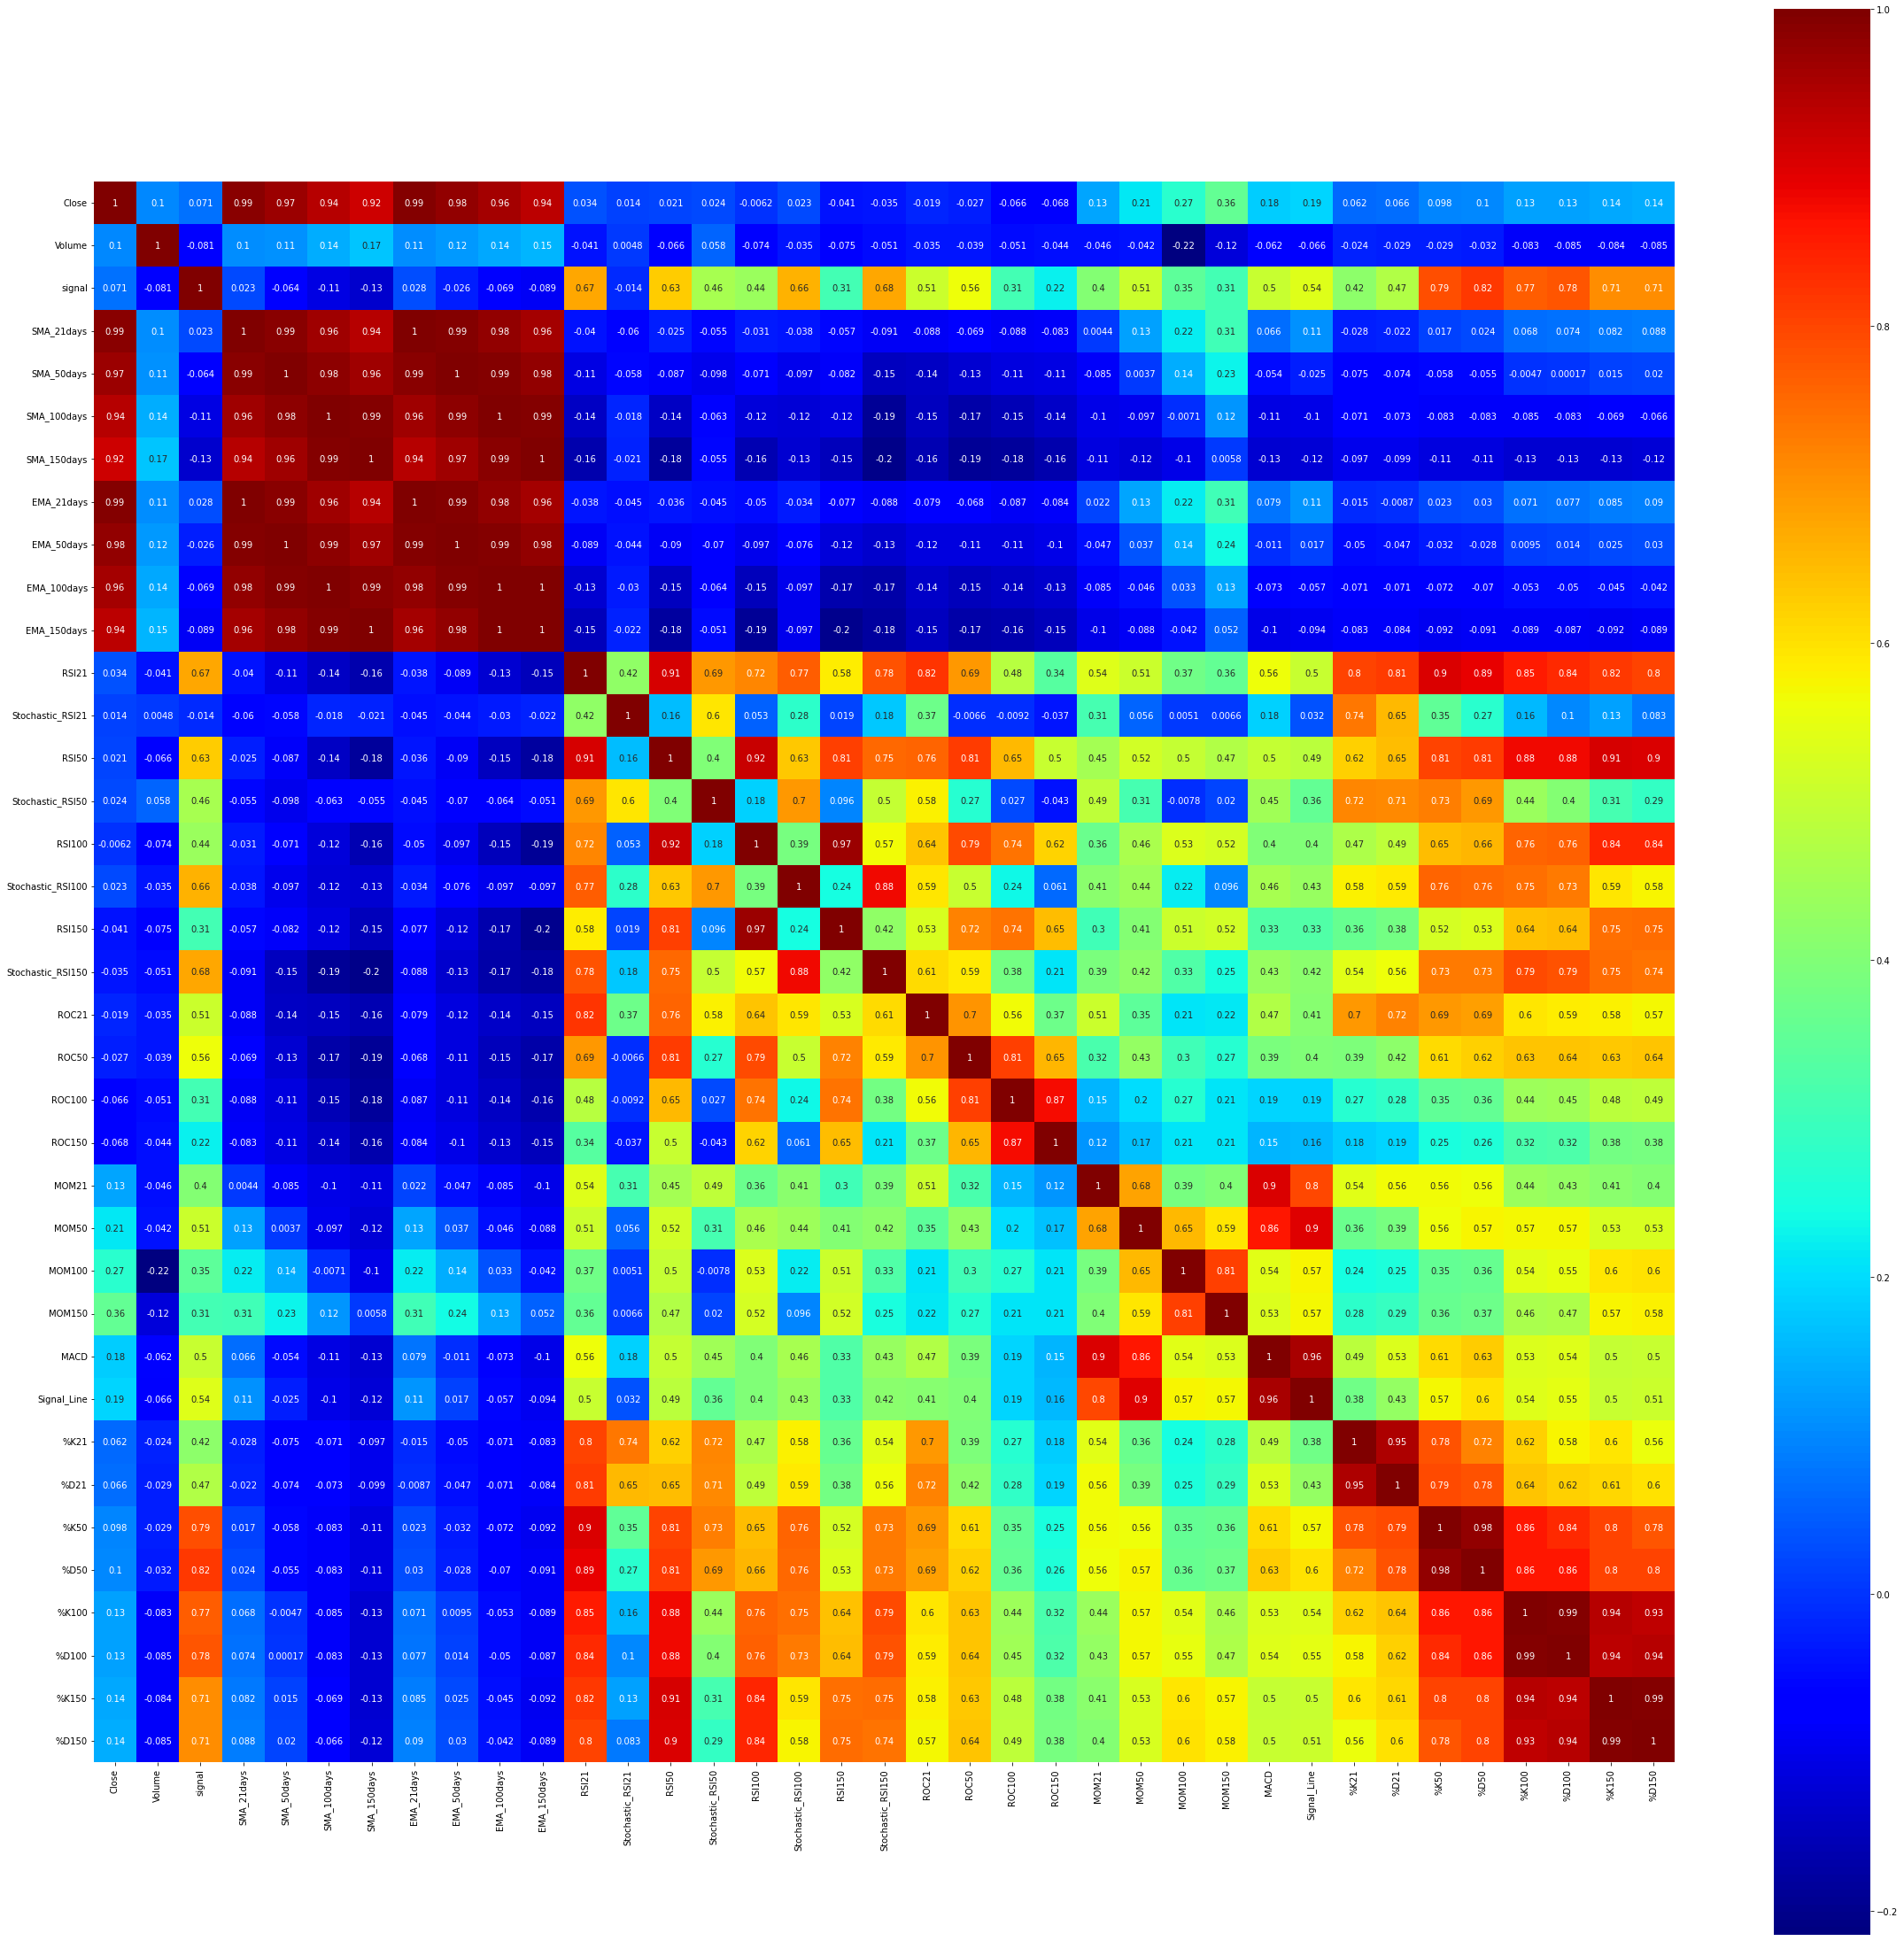

In [30]:
correlation = df.corr()
plt.figure(figsize=(40,40))
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='jet')

In [31]:
df = df.dropna(axis=0)

In [32]:
val_size = 0.2
seed = 42
val = int(df.shape[0]*0.8)
subset = df.iloc[-val:]
X = subset.loc[:, df.columns != 'signal']
y = subset['signal']

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=val_size, random_state=seed)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [34]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ETC', ExtraTreesClassifier()))
models.append(('SVC', SVC()))
models.append(('NB', GaussianNB()))

In [35]:
num_folds = 10
SEED = 43
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [36]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.545238 (0.161218)
KNN: 0.529789 (0.043697)
CART: 0.973392 (0.012793)
LDA: 0.952369 (0.015206)
NN: 0.588018 (0.074208)
AB: 0.975495 (0.010467)
GBM: 0.975495 (0.011779)
RF: 0.976194 (0.011343)
ETC: 0.974796 (0.012171)
SVC: 0.538225 (0.038148)
NB: 0.537541 (0.037241)


Saving figure ETH prediction - Models Evaluation


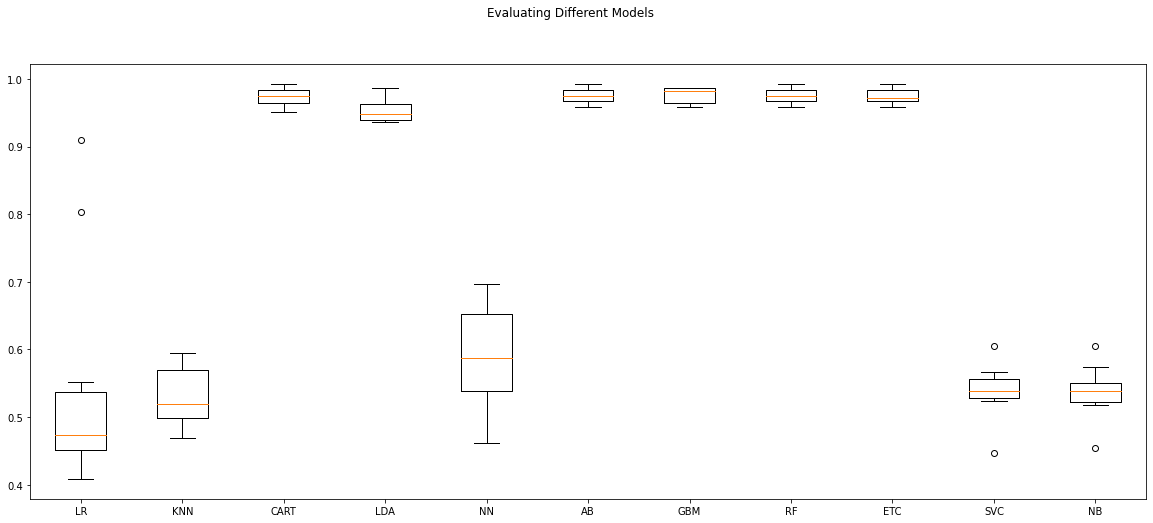

In [37]:
fig = plt.figure()
fig.suptitle('Evaluating Different Models')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(20,8)
save_fig('ETH prediction - Models Evaluation', tight_layout=False)
plt.show()

LR, KNN, NN, SVC, NB seems to perform very poorly when our dataframe is presented, having expected nonlinear relationship between predicted variable and tthe features. 

CART, LDA, Adaboost, Grad boosting, RF are the best valid options of models to choose for the optimization process. We'll see how well the predictions are for each of them

In [38]:
RandomForestClassifier?

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.

Read more in the :ref:`User Guide <forest>`.

Parameters
----------
n_estimators : int, default=100
    The number of trees in the forest.


In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
n_estimators = [20,80]
max_depth=[5,10]
criterion = ['gini','entropy']
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_scaled, y_train)

In [40]:
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print('#%d %f (%f) with %r' % (rank, mean, stdev, param))

Best: 0.980395 using {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#7 0.974106 (0.017409) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#4 0.978287 (0.014483) with {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#1 0.980395 (0.012017) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#3 0.979696 (0.012283) with {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#8 0.971279 (0.014131) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#5 0.977598 (0.014585) with {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#6 0.975490 (0.013703) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#1 0.980395 (0.010261) with {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


### FINALIZE MODEL

Modify the model again from the best criteria... criterion=entropy, max_depth = 10, n_estimator=80

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [42]:
model = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=80, n_jobs=-1) #rbf is default kernel
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=80,
                       n_jobs=-1)

In [43]:
predictions = model.predict(X_val)

In [44]:
print(accuracy_score(y_val, predictions))

0.9859943977591037


In [45]:
print(confusion_matrix(y_val, predictions))

[[158   1]
 [  4 194]]


In [46]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       159
         1.0       0.99      0.98      0.99       198

    accuracy                           0.99       357
   macro avg       0.99      0.99      0.99       357
weighted avg       0.99      0.99      0.99       357



Model predicts with 98-99% accuracy! POGGIES

Saving figure Feature Importance


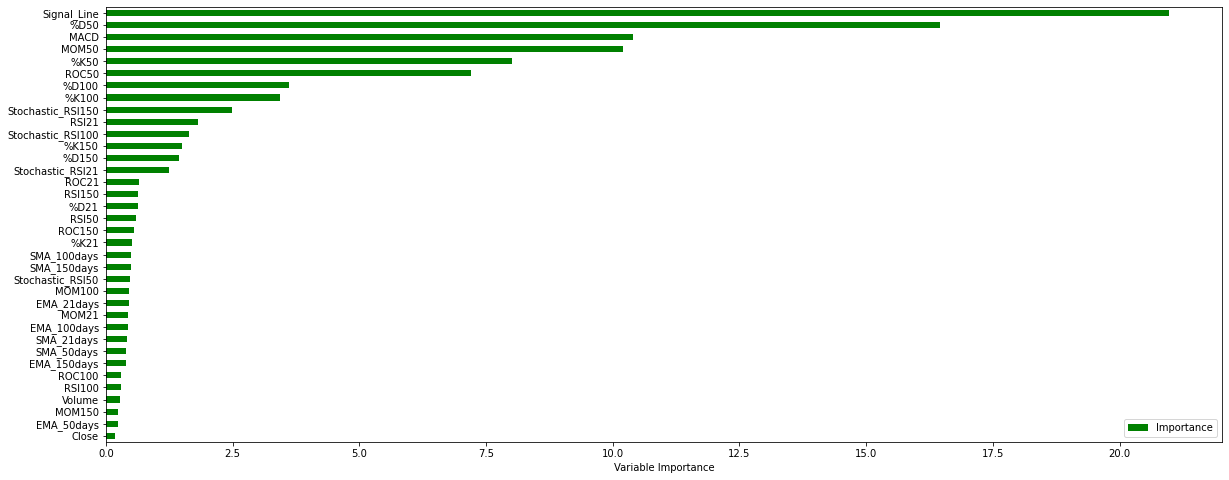

In [47]:
feat_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
feat_importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='g', figsize=(20,8))
plt.xlabel('Variable Importance')
save_fig('Feature Importance', tight_layout=False)
plt.show()

### Backtesting

In [48]:
backtest = pd.DataFrame(index=X_val.index)
backtest['signal pred'] = predictions
backtest['signal actual'] = y_val
backtest['market return'] = X_val['Close'].pct_change()
backtest['actual return'] = backtest['market return'] * backtest['signal actual'].shift(1)
backtest['strat return'] = backtest['market return'] * backtest['signal pred'].shift(1)
backtest = backtest.reset_index()

In [49]:
backtest.head(5)

,index,signal pred,signal actual,market return,actual return,strat return
0,1970,1.0,1.0,NaN,NaN,NaN
1,1677,0.0,0.0,-0.848730,-0.84873,-0.84873
2,1945,0.0,0.0,4.990923,0.00000,0.00000
3,886,0.0,0.0,-0.877401,-0.00000,-0.00000
4,1587,1.0,1.0,-0.153199,-0.00000,-0.00000


Saving figure Backtest - strat return vs actual return histogram


<Figure size 432x288 with 0 Axes>

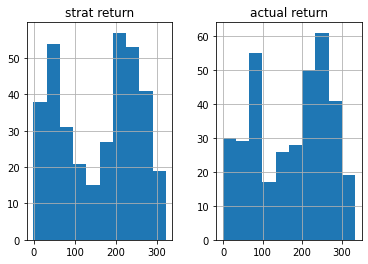

In [50]:
fig = plt.figure()
fig.suptitle('Backtest - strat return vs actual return histogram')
backtest[['strat return','actual return']].cumsum().hist()
save_fig('Backtest - strat return vs actual return histogram',tight_layout=False)
plt.show()

Saving figure Backtest - strat return vs actual return


<Figure size 432x288 with 0 Axes>

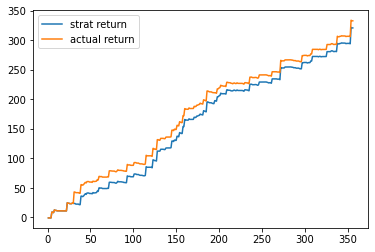

In [51]:
fig = plt.figure()
fig.suptitle('Backtest - strat return vs actual return')
backtest[['strat return','actual return']].cumsum().plot()
save_fig('Backtest - strat return vs actual return', tight_layout=False)
plt.show()

magnitude is literally the same. potential can-kicking for what's about to be a bullish movement in the future...
